In [47]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the CSV file into a DataFrame
data = pd.read_csv('../data/student_sleep_patterns.csv')

# Display basic information about the DataFrame
data.info()

# Display summary statistics for numerical columns
data.describe()

# Display the number of missing values in each column
data.isnull().sum()

# Display the unique values in each column
for column in data.columns:
    print(f"{column}: {data[column].unique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           500 non-null    int64  
 1   Age                  500 non-null    int64  
 2   Gender               500 non-null    object 
 3   University_Year      500 non-null    object 
 4   Sleep_Duration       500 non-null    float64
 5   Study_Hours          500 non-null    float64
 6   Screen_Time          500 non-null    float64
 7   Caffeine_Intake      500 non-null    int64  
 8   Physical_Activity    500 non-null    int64  
 9   Sleep_Quality        500 non-null    int64  
 10  Weekday_Sleep_Start  500 non-null    float64
 11  Weekend_Sleep_Start  500 non-null    float64
 12  Weekday_Sleep_End    500 non-null    float64
 13  Weekend_Sleep_End    500 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 54.8+ KB
Student_ID: [  1   2   3   4   5

In [48]:
# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
data['Gender'] = data['Gender'].astype('category').cat.codes
data['University_Year'] = data['University_Year'].astype('category').cat.codes

# Separate features and target
X = data.drop(['Student_ID', 'Sleep_Quality'], axis=1)
y = data['Sleep_Quality']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [49]:
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
report = classification_report(y_test, y_pred)
print(report)



Accuracy: 0.06
              precision    recall  f1-score   support

           1       0.17      0.17      0.17        18
           2       0.18      0.22      0.20         9
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         7
          10       0.17      0.08      0.11        12

    accuracy                           0.06       100
   macro avg       0.05      0.05      0.05       100
weighted avg       0.07      0.06      0.06       100



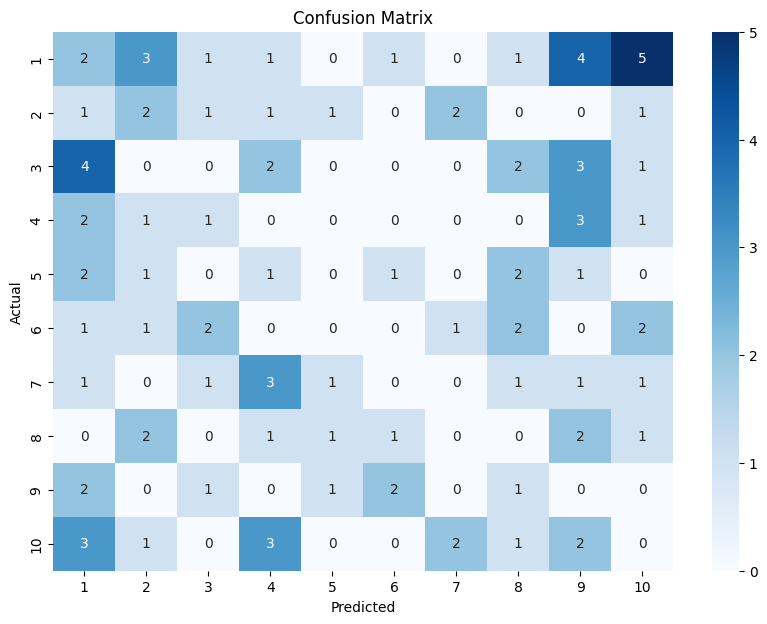

In [50]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

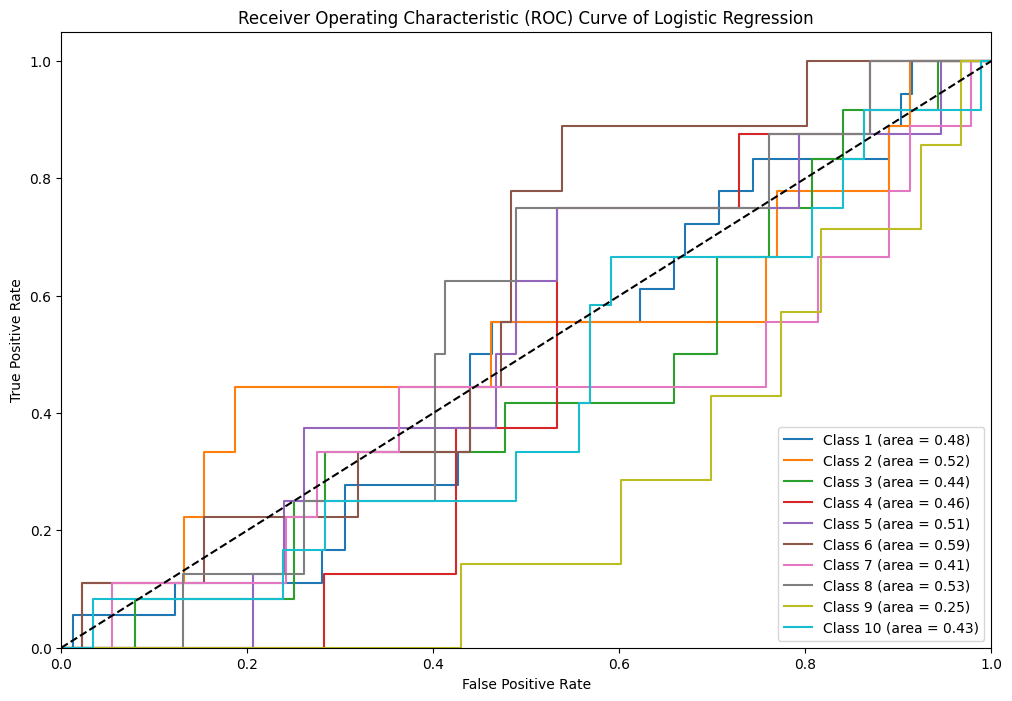

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[1,2,3,4,5,6,7,8,9,10])
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Logistic Regression')
plt.legend(loc='lower right')
plt.show()

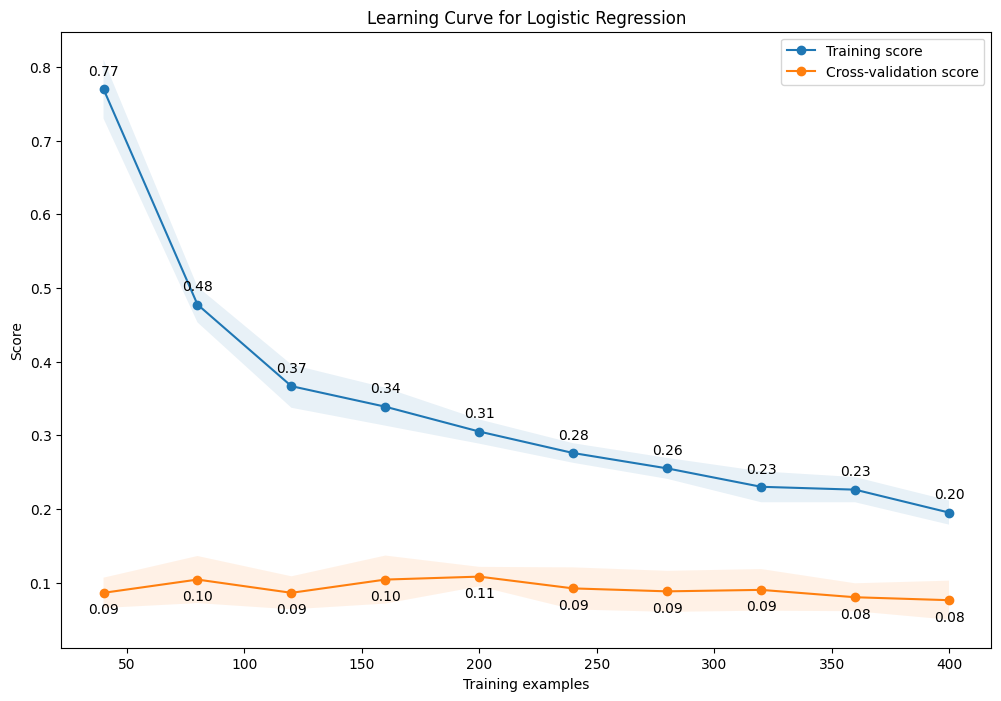

In [52]:
import numpy as np
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")

# Annotate the points with their values
for i in range(len(train_sizes)):
    plt.annotate(f'{train_scores_mean[i]:.2f}', (train_sizes[i], train_scores_mean[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{test_scores_mean[i]:.2f}', (train_sizes[i], test_scores_mean[i]), textcoords="offset points", xytext=(0,-15), ha='center')

plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training examples')
plt.legend(loc='best')
plt.ylabel('Score')
plt.show()
